## Notebook to plot ACC Seizure Detection Plots

In [1]:
# imports
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import acc_seizure_modelling as asm

In [2]:
data = pd.read_parquet('./data/X_acc_20S.parquet')

# remove patient YJWN
data = data.loc[data['patient'] != 'YWJN'].copy()

In [3]:
data.groupby('onset')['seizure_type'].max().value_counts()

seizure_type
                    45
FWIA                20
FBTC                12
Funk                 5
E                    2
FIAS                 2
F                    1
FAS                  1
Focal cognitiva      1
Name: count, dtype: int64

### Seizure Templates vs Baseline Templates

In [2]:
from preepiseizures.src.Patient import patient_class


patient = 'AGGA'
patient_class_ = patient_class(patient)
patient_class_.get_seizure_annotations()
data = pd.read_parquet(f'./data/{patient}_acc_seizures.parquet')

In [3]:
data['relative_time'] = data['datetime_chestbit'] - data['datetime_chestbit'].min()

cols_of_interest = ['datetime_chestbit', 'relative_time', 'ACCX_chestbit', 'ACCY_chestbit', 'ACCZ_chestbit', 'acc_magnitude_chestbit']

fig = make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.02)
start_date = pd.to_datetime('2019-11-01 00:00:00')
color_list = ['red', 'purple', 'lightblue', 'orange', 'green', 'yellow', 'pink', 'brown', 'black', 'grey']
resample_data = pd.DataFrame()
for seizure in data['seizure'].unique():
    idx = int(seizure)
    onset = patient_class_.seizure_table.iloc[idx]['Timestamp']
    print(onset, patient_class_.seizure_table.iloc[idx]['Focal / Generalisada'])
    data_idxs = data.loc[data['seizure']==seizure].index
    seizure_data = data.loc[data_idxs].copy()
    seizure_data['relative_time'] = seizure_data['datetime_chestbit'] - onset
    seizure_data['relative_time'] = seizure_data['relative_time'] + start_date
    seizure_data.index = seizure_data['datetime_chestbit']
    seizure_data = seizure_data.resample('1S')[cols_of_interest].mean()
    fig.add_trace(go.Scatter(x=seizure_data['relative_time'], y=seizure_data['ACCX_chestbit'], 
                             name=f'seizure {seizure}', marker=dict(color=color_list[idx])), row=1, col=1)
    fig.add_trace(go.Scatter(x=seizure_data['relative_time'], y=seizure_data['ACCY_chestbit'], 
                             name=f'seizure {seizure}', marker=dict(color=color_list[idx])), row=2, col=1)
    fig.add_trace(go.Scatter(x=seizure_data['relative_time'], y=seizure_data['ACCZ_chestbit'], 
                             name=f'seizure {seizure}', marker=dict(color=color_list[idx])), row=3, col=1)
    activity_index = pd.DataFrame()
    activity_index['acc_magnitude_chestbit'] = seizure_data['acc_magnitude_chestbit'].resample('5S').std()
    activity_index['relative_time'] = seizure_data['relative_time'].resample('5S').min()
    fig.add_trace(go.Scatter(x=activity_index['relative_time'], y=activity_index['acc_magnitude_chestbit'], name=f'seizure {seizure}', 
                              marker=dict(color=color_list[idx])), row=4, col=1)
    fig.add_trace(go.Scatter(x=seizure_data['relative_time'], y=seizure_data['acc_magnitude_chestbit'], name=f'seizure {seizure}', 
                             marker=dict(color=color_list[idx])), row=5, col=1)
    
    fig.add_vline(x=start_date, row=1, col=1)
    fig.add_vline(x=start_date, row=2, col=1)
    fig.add_vline(x=start_date, row=3, col=1)
    fig.add_vline(x=start_date, row=4, col=1)


#fig.update_layout(
#    xaxis_range=[seizure_data['relative_time'].min(), seizure_data['relative_time'].max()],)
#fig['layout']['xaxis'].update(dict( type="date" ))
fig.update_xaxes(type='date')
#fig.update_traces(connectgaps=False)
#fig.update_xaxes(
#    ticktext=["End of Q1", "End of Q2", "End of Q3", "End of Q4"],
#    tickvals=["2016-04-01", "2016-07-01", "2016-10-01"],)
fig.show()

2021-12-13 23:04:26 FBTC
2021-12-14 04:52:16 FBTC
2021-12-14 06:25:47 FBTC
2021-12-14 07:58:52 FBTC


In [14]:
import biosppy as bp

cols_of_interest = ['datetime_chestbit', 'relative_time', 'ACCX_chestbit', 'ACCY_chestbit', 'ACCZ_chestbit', 'acc_magnitude_chestbit']

seizure_data = data.loc[data['seizure']==0].copy()
seizure_data.index = seizure_data['datetime_chestbit']
for col in ['ACCX_chestbit', 'ACCY_chestbit', 'ACCZ_chestbit', 'acc_magnitude_chestbit']:
    seizure_data[col] = bp.signals.tools.filter_signal(seizure_data[col].values, ftype='butter', band='bandpass', order=4, frequency=[2, 14], sampling_rate=1000)['signal']
#filter_acc = bp.signals.tools.filter_signal(seizure_data['ACCX_chestbit'].values, ftype='butter', band='bandpass', order=4, frequency=[0.5, 10], sampling_rate=1000)
#ss_data = seizure_data.copy()
ss_data = seizure_data[cols_of_interest].resample('0.05S').mean()
fig = px.line(ss_data, x='datetime_chestbit', y='ACCY_chestbit')
fig.add_vline(x=patient_class_.seizure_table.iloc[0]['Timestamp'], line_width=3, line_dash="dash", line_color="green")
fig.show()
ss_data.head()

datetime_chestbit          relative_time  \
datetime_chestbit                                                              
2021-12-13 22:34:48.850 2021-12-13 22:34:48.892516096 0 days 00:00:00.006500   
2021-12-13 22:34:48.900 2021-12-13 22:34:48.924515840 0 days 00:00:00.038500   
2021-12-13 22:34:48.950 2021-12-13 22:34:48.974515968 0 days 00:00:00.088500   
2021-12-13 22:34:49.000 2021-12-13 22:34:49.024515840 0 days 00:00:00.138500   
2021-12-13 22:34:49.050 2021-12-13 22:34:49.074515968 0 days 00:00:00.188500   

                         ACCX_chestbit  ACCY_chestbit  ACCZ_chestbit  \
datetime_chestbit                                                      
2021-12-13 22:34:48.850       0.189663      -0.798370      -0.001391   
2021-12-13 22:34:48.900       0.798641      -0.755967      -0.004922   
2021-12-13 22:34:48.950       0.368724      -0.103377       0.012716   
2021-12-13 22:34:49.000      -0.507908      -0.134146      -0.000986   
2021-12-13 22:34:49.050      -0.026724       0.132248      -0.004435   

                         acc_magnitude_chestbit  
datetime_chestbit                                
2021-12-13 22:34:48.850               -0.067358  
2021-12-13 22:34:48.900                0.158925  
2021-12-13 22:34:48.950                0.154703  
2021-12-13 22:34:49.000               -0.402412  
2021-12-13 22:34:49.050               -0.012714

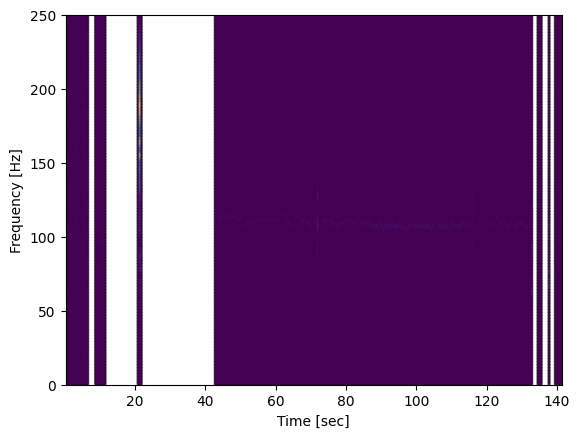

In [16]:
import matplotlib.pyplot as plt
import scipy.signal as signal
fs = 500
#seizure_data_col = bp.signals.tools.filter_signal(seizure_data[col].values, ftype='butter', band='bandpass', order=4, frequency=[2, 14], sampling_rate=1000)['signal']
seizure_data_col = ss_data['ACCY_chestbit'].values
f, t, Sxx = signal.spectrogram(seizure_data_col, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
start_date = pd.to_datetime('2019-11-01 00:00:00')

In [16]:
fbtc_data = data.loc[data['Y'] == 0].copy()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)

fig = px.line(fbtc_data, x='relative_time', y=['minmax_acc_magnitude'], color='onset', title='Accelerometer data')

fbtc_data = data.loc[data['seizure_type'] == 'FBTC'].copy()
fig.show()

fig = px.line(fbtc_data, x='relative_time', y=['minmax_ACCX'], color='onset', title='Accelerometer data')


fig.show()

In [18]:
fbtc_data['patient'].unique()

array(['AGGA', 'VNVW', 'YIVL', 'WOSQ', 'BLIW'], dtype=object)

In [22]:
feats = [col for col in data.columns if 'acc' in col.lower()]
fig = px.violin(max_data, color='Y', x=feats)
fig.show()

In [77]:
data.dropna(subset=feats, inplace=True)
x = data[feats]
y = data['Y']

In [79]:
# Training and Testing

# divide data into training and testing with cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

log_reg_params = [ {"C":0.01}, {"C":0.1}, {"C":1}, {"C":10} ]
dec_tree_params = [{"criterion": "gini"}, {"criterion": "entropy"}]
rand_for_params = [{"criterion": "gini"}, {"criterion": "entropy"}]
kneighbors_params = [{"n_neighbors":3}, {"n_neighbors":5}]
naive_bayes_params = [{}]
svc_params = [{"C":0.01}, {"C":0.1}, {"C":1}]


modelclasses = [
    ["log regression", LogisticRegression, log_reg_params],
    ["decision tree", DecisionTreeClassifier, dec_tree_params],
    ["random forest", RandomForestClassifier, rand_for_params],
    ["k neighbors", KNeighborsClassifier, kneighbors_params],
    ["naive bayes", GaussianNB, naive_bayes_params],
    # ["support vector machines", SVC, svc_params]
]

insights = []
for modelname, Model, params_list in modelclasses:
    print('Training...', modelname)
    for params in params_list:
        model = Model(**params)
        for user in set(data['patient']):
            #cols = [col for col in X.columns if '' in col]
            X_test = x.loc[data['patient'] == user]
            y_test = y.loc[data['patient'] == user]
            X_train = x.loc[data['patient'] != user]
            y_train = y.loc[data['patient'] != user]

            scale = StandardScaler().fit(X_train)
            X_train = scale.transform(X_train)
            X_test = scale.transform(X_test)

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            insights.append((modelname, model, params, score, user))


Training... log regression
Training... decision tree
Training... random forest
Training... k neighbors
Training... naive bayes


In [80]:
insights.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score, user in insights:
    print(modelname, params, score, user)

log regression {'C': 0.01} 0.6190476190476191 YIVL
log regression {'C': 0.1} 0.6190476190476191 YIVL
log regression {'C': 1} 0.6190476190476191 YIVL
log regression {'C': 10} 0.6190476190476191 YIVL
decision tree {'criterion': 'gini'} 0.47619047619047616 YIVL
decision tree {'criterion': 'entropy'} 0.42857142857142855 YIVL
random forest {'criterion': 'gini'} 0.2857142857142857 YIVL
random forest {'criterion': 'entropy'} 0.35714285714285715 YIVL
k neighbors {'n_neighbors': 3} 0.35714285714285715 YIVL
k neighbors {'n_neighbors': 5} 0.4523809523809524 YIVL
naive bayes {} 0.5476190476190477 YIVL
log regression {'C': 0.01} 0.8571428571428571 WOSQ
log regression {'C': 0.1} 0.8571428571428571 WOSQ
log regression {'C': 1} 0.8571428571428571 WOSQ
log regression {'C': 10} 0.8571428571428571 WOSQ
decision tree {'criterion': 'gini'} 0.5714285714285714 WOSQ
decision tree {'criterion': 'entropy'} 0.5714285714285714 WOSQ
random forest {'criterion': 'gini'} 0.42857142857142855 WOSQ
random forest {'crite

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

all_scores = []
for user in set(data['patient']):

    X_test = x.loc[data['patient'] == user]
    y_test = y.loc[data['patient'] == user]
    X_train = x.loc[data['patient'] != user]
    y_train = y.loc[data['patient'] != user]

    scale = StandardScaler().fit(X_train)
    X_train = scale.transform(X_train)
    X_test = scale.transform(X_test)

    model = RandomForestClassifier(random_state=42, criterion='entropy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    all_scores.append(score)
    print(user, score)
    table_features = pd.DataFrame()
    table_features['importance'] = model.feature_importances_
    table_features['feature'] = x.columns
    table_features.sort_values(by='importance', ascending=False, inplace=True)
    #print(table_features.head(6))
print('mean', np.mean(all_scores))

WOSQ 0.30769230769230765
AGGA 0.3333333333333333
BLIW 0.7567567567567567
VNVW 0.4
UWEF 0.8533333333333334
YIVL 0.18181818181818182
BSEA 0.30000000000000004
CNSV 0.33962264150943394
OFUF 0.5217391304347826
RAFI 0.19999999999999998
PRBQ 0.18181818181818182
mean 0.3978285333360283


In [29]:
X_train['patient'].unique()

array(['UWEF', 'PRBQ', 'YWJN', 'CNSV', 'VNVW', 'OFUF', 'RAFI', 'BSEA',
       'YIVL', 'AGGA', 'BLIW', 'WOSQ'], dtype=object)

In [28]:
X_test['patient'].unique()

array(['RAFI', 'YWJN', 'UWEF', 'BSEA', 'VNVW', 'AGGA', 'CNSV', 'BLIW',
       'YIVL'], dtype=object)